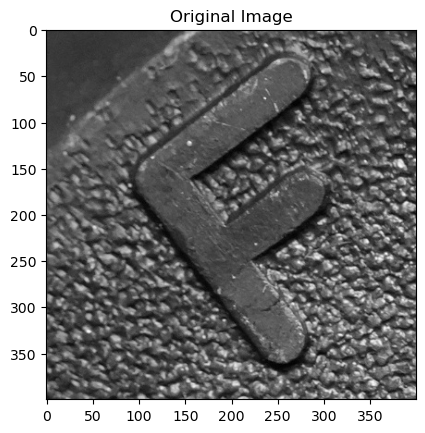

: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift

# Load the image
image_path = 'database/202404-inkan/output-resize/DSC02098.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
diffimage = cv2.imread('database/202404-inkan/output-resize/DSC02148.JPG', cv2.IMREAD_GRAYSCALE)

cropimage1 = image[300:700, 450:850] #(y:y,x:x)
cropimage2 = diffimage[300:700, 450:850] #(y:y,x:x)
  

# Display the original image
plt.imshow(cropimage1, cmap='gray')
plt.title('Original Image')
plt.show()

# def diffimg(img0,img1):
#   # 将图像转换为灰度图
#   #gray_image1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
#   #gray_image2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#   # 计算两个图像的差异
#   diff = cv2.absdiff(img0, img1)
#   # 设置一个阈值，将差异值大于阈值的像素设为白色
#   _, threshold = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY)
#   # 找到白色区域的轮廓
#   contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   # 创建空白图像
#   diffimg = np.zeros_like(img0)
#   cv2.drawContours(diffimg, contours, -1, (0, 255, 0), 2)
#   return diffimg

# diffimg = diffimg(cropimage1,cropimage2)
# plt.imshow(diffimg)

def opticalflow(img0,img1):
  # Shi-Tomasi角点检测参数
  feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
  # lucas kanade光流参数
  lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
  # 寻找初始关键点
  p0 = cv2.goodFeaturesToTrack(img0, mask=None, **feature_params)
  # 计算光流
  p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
  # 选择好的点
  good_new = p1[st == 1]
  good_old = p0[st == 1]
  # 绘制轨迹
  mask = np.zeros_like(img0)
  for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel().astype(int)
    c, d = old.ravel().astype(int)
    mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
    img1 = cv2.circle(img1, (a, b), 5, (0, 0, 255), -1)
  img = cv2.add(img1, mask)
  return img

opticalflowimg = opticalflow(cropimage1,cropimage2)
# 可视化结果
cv2.imshow('Optical Flow', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


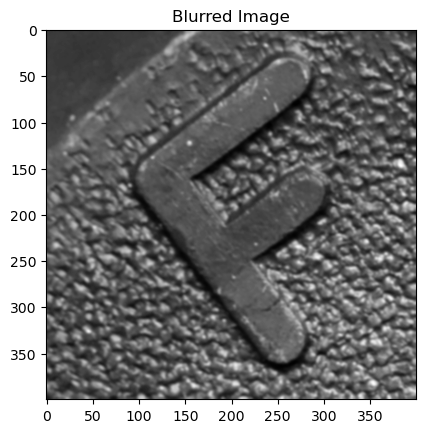

In [7]:
# Apply Gaussian Blur to smooth the image
blurred_image = cv2.GaussianBlur(cropimage1, (5, 5), 0)

# Display the blurred image
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.show()


In [12]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load HED model
class HEDModel(torch.nn.Module):
    def __init__(self):
        super(HEDModel, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'hed', pretrained=True)

    def forward(self, x):
        return self.model(x)

# Function to process image and apply HED
def apply_hed(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)

    # Load model
    model = HEDModel().eval()

    # Apply HED
    with torch.no_grad():
        edges = model(input_image).squeeze().cpu().numpy()

    return edges

# Path to your image
#image_path = '/mnt/data/image.png'

# Apply HED and display results
edges = apply_hed(image_path)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('HED Edges')
plt.show()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/br-python/.cache/torch/hub/v0.10.0.zip


RuntimeError: Cannot find callable hed in hubconf

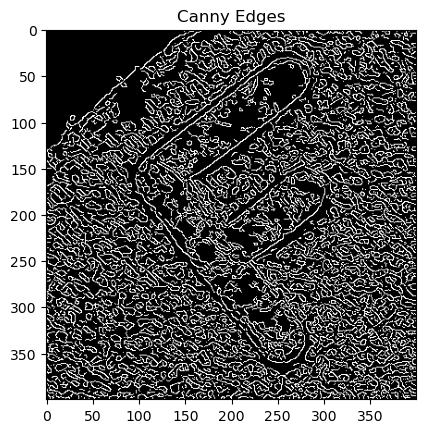

In [20]:
# Use Canny edge detection
edges = cv2.Canny(blurred_image, 10, 50)

# Display the edges
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.show()



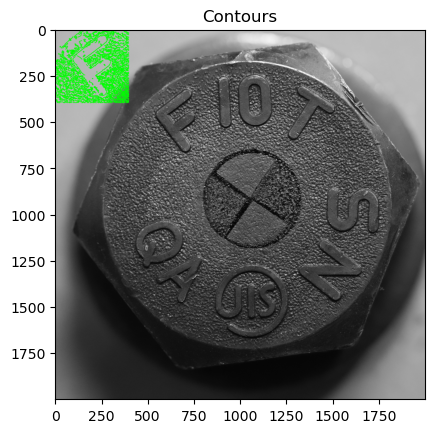

In [10]:
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Display the image with contours
plt.imshow(contour_image)
plt.title('Contours')
plt.show()


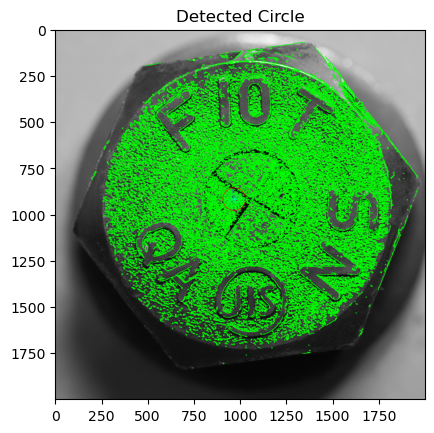

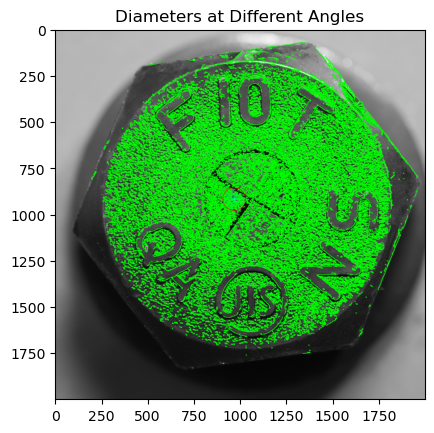

Normalized Diameters (in mm): [22. 22. 22. 22. 22. 22. 22. 22. 22. 22.]


In [6]:
# Assuming the largest contour is the circle we are interested in
contour = max(contours, key=cv2.contourArea)
(x, y), radius = cv2.minEnclosingCircle(contour)
center = (int(x), int(y))
radius = int(radius)

# Draw the circle
circle_image = cv2.circle(contour_image, center, radius, (255, 0, 0), 2)

# Display the image with the detected circle
plt.imshow(circle_image)
plt.title('Detected Circle')
plt.show()

# Calculate diameters at different angles
angles = np.linspace(0, 2*np.pi, 10)
diameters = []
for angle in angles:
    x1 = int(center[0] + radius * np.cos(angle))
    y1 = int(center[1] + radius * np.sin(angle))
    x2 = int(center[0] - radius * np.cos(angle))
    y2 = int(center[1] - radius * np.sin(angle))
    cv2.line(circle_image, (x1, y1), (x2, y2), (0, 255, 255), 1)
    diameters.append(2 * radius)

# Display the image with diameter lines
plt.imshow(circle_image)
plt.title('Diameters at Different Angles')
plt.show()

# Convert diameters to pixel values and normalize
diameters = np.array(diameters)
normalized_diameters = diameters * (22 / np.mean(diameters))  # 22mm is the actual diameter
print("Normalized Diameters (in mm):", normalized_diameters)


# 位相变换

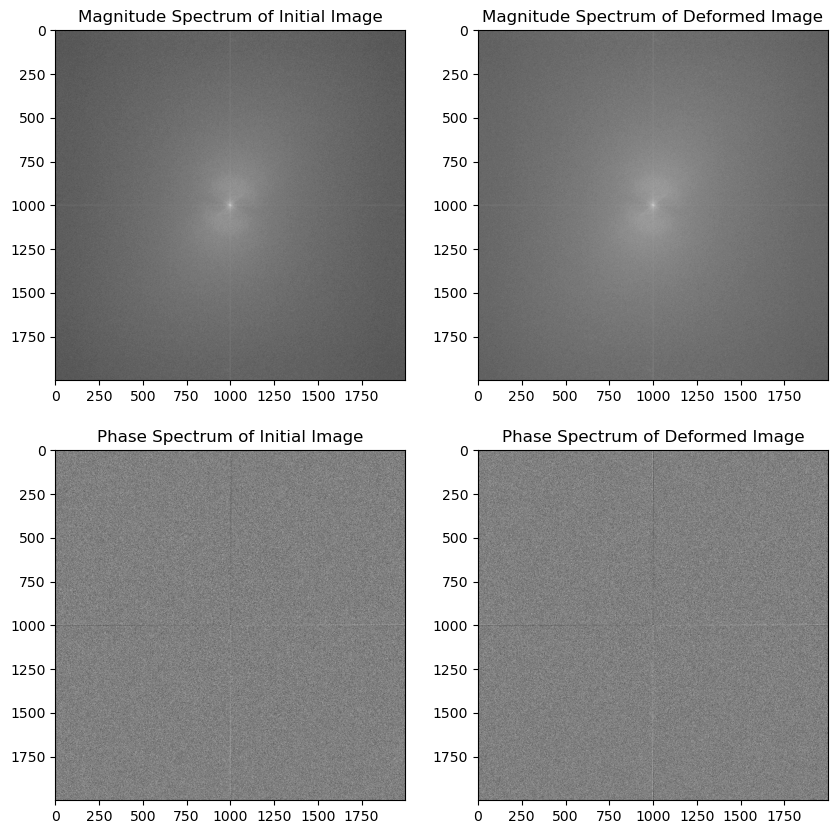

In [41]:
# Apply Fourier Transform to both images
f_transform_initial = fft2(image)
f_shift_initial = fftshift(f_transform_initial)
magnitude_spectrum_initial = np.abs(f_shift_initial)
phase_spectrum_initial = np.angle(f_shift_initial)

f_transform_deformed = fft2(diffimage)
f_shift_deformed = fftshift(f_transform_deformed)
magnitude_spectrum_deformed = np.abs(f_shift_deformed)
phase_spectrum_deformed = np.angle(f_shift_deformed)

# Display magnitude and phase spectra
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.log(1 + magnitude_spectrum_initial), cmap='gray')
plt.title('Magnitude Spectrum of Initial Image')
plt.subplot(2, 2, 2)
plt.imshow(np.log(1 + magnitude_spectrum_deformed), cmap='gray')
plt.title('Magnitude Spectrum of Deformed Image')
plt.subplot(2, 2, 3)
plt.imshow(phase_spectrum_initial, cmap='gray')
plt.title('Phase Spectrum of Initial Image')
plt.subplot(2, 2, 4)
plt.imshow(phase_spectrum_deformed, cmap='gray')
plt.title('Phase Spectrum of Deformed Image')
plt.show()


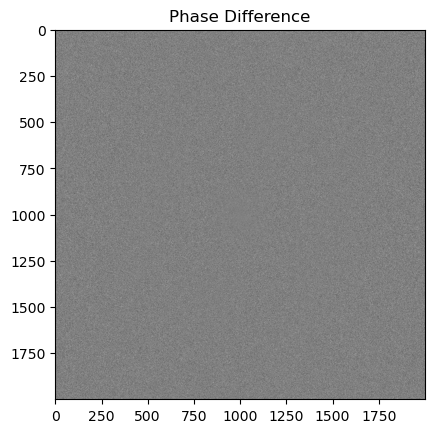

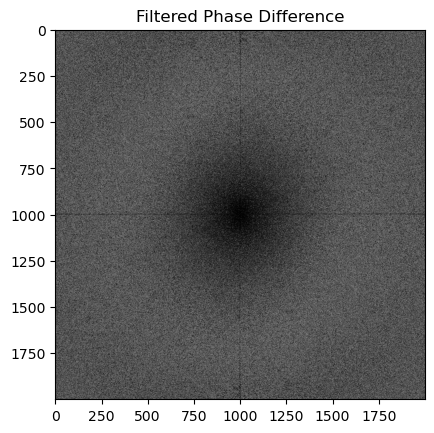

In [43]:
# Calculate the phase difference
phase_difference = phase_spectrum_deformed - phase_spectrum_initial

# Display the phase difference
plt.imshow(phase_difference, cmap='gray')
plt.title('Phase Difference')
plt.show()

# Apply a high-pass filter to the phase difference (optional)
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
mask = np.ones((rows, cols), np.uint8)
r = 30  # Radius of the high-pass filter
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0

# Apply the mask
f_shift_diff = fftshift(fft2(phase_difference)) * mask

# Inverse Fourier Transform
f_ishift_diff = fftshift(f_shift_diff)
phase_diff_filtered = np.abs(ifft2(f_ishift_diff))

# Display the filtered phase difference
plt.imshow(phase_diff_filtered, cmap='gray')
plt.title('Filtered Phase Difference')
plt.show()


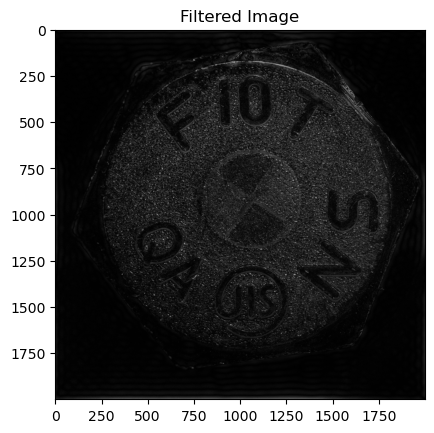

In [34]:
# Define a high-pass filter
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2
mask = np.ones((rows, cols), np.uint8)
r = 30  # Radius of the high-pass filter
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
mask[mask_area] = 0

# Apply the mask
f_shift = f_shift * mask

# Inverse Fourier Transform
f_ishift = fftshift(f_shift)
img_back = ifft2(f_ishift)
img_back = np.abs(img_back)

# Display the filtered image
plt.imshow(img_back, cmap='gray')
plt.title('Filtered Image')
plt.show()


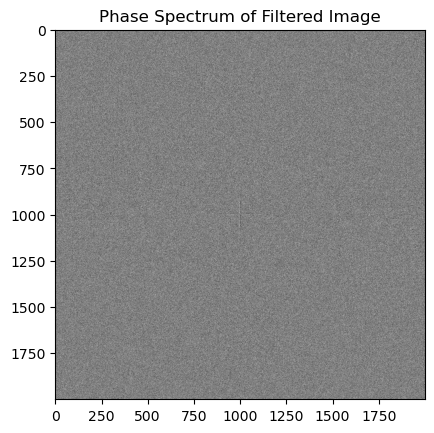

In [35]:
# Extract phase information again from the filtered image
f_transform_filtered = fft2(img_back)
f_shift_filtered = fftshift(f_transform_filtered)
phase_spectrum_filtered = np.angle(f_shift_filtered)

# Display the phase spectrum of the filtered image
plt.imshow(phase_spectrum_filtered, cmap='gray')
plt.title('Phase Spectrum of Filtered Image')
plt.show()

# Calculate phase differences (optional step for detailed analysis)
# phase_difference = phase_spectrum_filtered - initial_phase_spectrum (if initial phase spectrum is known)
